In [31]:
import pandas as pd
import numpy as np
import os
import cv2
from sklearn.multioutput import MultiOutputClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import matplotlib.pyplot as plt

# Cargar CSVs
train_df = pd.read_csv('Dataset-SupermarketImages/annotations_multietiqueta.csv')
val_df = pd.read_csv('Dataset-SupermarketImages/annotations_val_multietiqueta.csv')

base_path = 'Dataset-SupermarketImages'


In [32]:
def load_images_and_labels(df, base_path, image_size=(224, 224)):
    images = []
    labels = []

    for _, row in df.iterrows():
        img_path = os.path.join(base_path, row['image'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.resize(img, image_size)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img.flatten())

        labels.append(row[1:].values.astype(int))  # todas las columnas desde la 2da

    return np.array(images), np.array(labels)

x_train, y_train = load_images_and_labels(train_df, base_path)
x_val, y_val = load_images_and_labels(val_df, base_path)


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multioutput import MultiOutputClassifier

# Escalar
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)

# Modelo
knn = KNeighborsClassifier(n_neighbors=3)
multi_knn = MultiOutputClassifier(knn)
multi_knn.fit(x_train_scaled, y_train)

# Predicción
y_pred = multi_knn.predict(x_val_scaled)

# Evaluación
from sklearn.metrics import classification_report
etiquetas = train_df.columns[1:]
print(classification_report(y_val, y_pred, target_names=etiquetas, zero_division=0))


                 precision    recall  f1-score   support

         Banana       0.86      1.00      0.92         6
         Orange       0.62      1.00      0.77         5
Red-Bell-Pepper       1.00      0.80      0.89         5
 aluminium-form       0.67      0.80      0.73         5
          bread       1.00      1.00      1.00         5
       cocaCola       1.00      0.22      0.36         9
        doritos       1.00      0.50      0.67        10
       red-bull       0.71      1.00      0.83         5
    shampoo-H&S       0.00      0.00      0.00         5
            tea       1.00      0.20      0.33         5
yogurt-toni-mix       0.33      1.00      0.50         5

      micro avg       0.70      0.65      0.67        65
      macro avg       0.75      0.68      0.64        65
   weighted avg       0.78      0.65      0.63        65
    samples avg       0.66      0.65      0.65        65



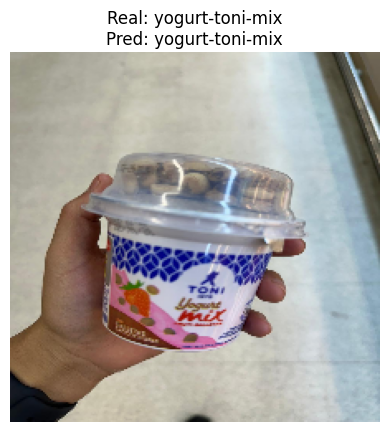

In [34]:
import random

# Elegimos una imagen aleatoria del set de validación
idx = random.randint(0, len(x_val) - 1)
img = x_val[idx].reshape(224, 224, 3)  # la imagen original escalada
real_labels = y_val[idx]
pred_labels = multi_knn.predict([x_val_scaled[idx]])[0]

# Obtener nombres de etiquetas
etiquetas = train_df.columns[1:]
etiquetas_verdaderas = [etiquetas[i] for i, v in enumerate(real_labels) if v == 1]
etiquetas_predichas = [etiquetas[i] for i, v in enumerate(pred_labels) if v == 1]

# Mostrar resultados
plt.imshow(img.astype(np.uint8))
plt.axis('off')
plt.title(f"Real: {', '.join(etiquetas_verdaderas)}\nPred: {', '.join(etiquetas_predichas)}")
plt.show()


Análisis: ¿Por qué shampoo es tan difícil de predecir?

Distancias promedio desde shampoo:
  Banana: 550.771
  Orange: 608.815
  Red-Bell-Pepper: 638.195
  aluminium-form: 467.002
  bread: 601.865
  cocaCola: 617.192
  doritos: 586.980
  red-bull: 448.647
  tea: 477.774
  yogurt-toni-mix: 462.109

Clase más similar: red-bull (distancia: 448.647)
Forma de imagen: (150528,)
Tamaño calculado: 224x224


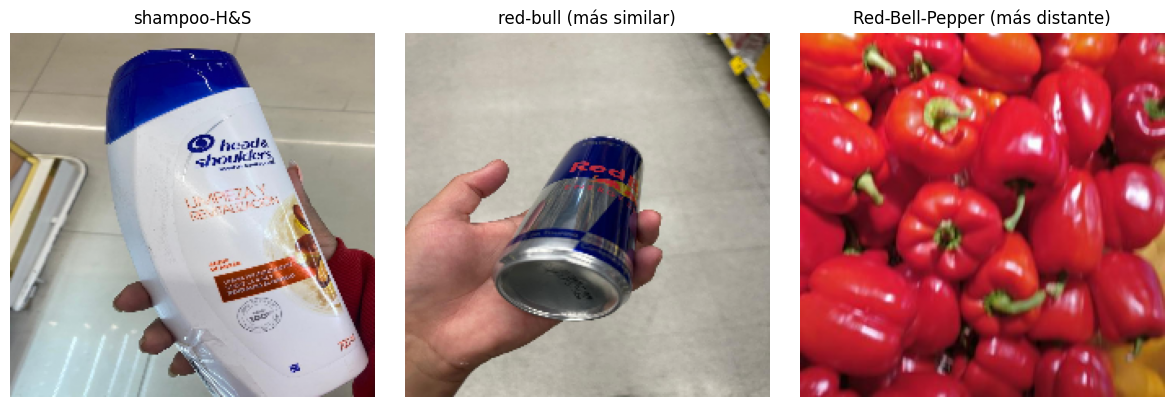

In [37]:
# ====== ANÁLISIS DE SIMILITUD DE PÍXELES ======
print("Análisis: ¿Por qué shampoo es tan difícil de predecir?")
print()

import numpy as np
from sklearn.metrics.pairwise import euclidean_distances

# Obtener índices de shampoo (actualizado para nuevo dataset)
shampoo_indices = class_indices['shampoo-H&S']
shampoo_samples = x_val_scaled[shampoo_indices]

print("Distancias promedio desde shampoo:")
distancias_promedio = []

for clase, indices in class_indices.items():
    if clase != 'shampoo-H&S':
        other_samples = x_val_scaled[indices]
        distances = euclidean_distances(shampoo_samples, other_samples)
        avg_distance = np.mean(distances)
        distancias_promedio.append((clase, avg_distance))
        print(f"  {clase}: {avg_distance:.3f}")

distancias_promedio.sort(key=lambda x: x[1])
print(f"\nClase más similar: {distancias_promedio[0][0]} (distancia: {distancias_promedio[0][1]:.3f})")

# Verificar dimensiones de imagen
img_shape = x_val[0].shape
print(f"Forma de imagen: {img_shape}")
img_size = int(np.sqrt(img_shape[0] / 3))
print(f"Tamaño calculado: {img_size}x{img_size}")

# Visualizar muestras más similares
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Imagen de shampoo
shampoo_idx = shampoo_indices[0]
shampoo_img = x_val[shampoo_idx].reshape(img_size, img_size, 3)
axes[0].imshow(shampoo_img / 255.0)
axes[0].set_title('shampoo-H&S')
axes[0].axis('off')

# Encontrar la muestra más similar de otra clase
clase_similar = distancias_promedio[0][0]
similar_indices = class_indices[clase_similar]
similar_samples = x_val_scaled[similar_indices]

distances = euclidean_distances([x_val_scaled[shampoo_idx]], similar_samples)[0]
most_similar_idx = similar_indices[np.argmin(distances)]
similar_img = x_val[most_similar_idx].reshape(img_size, img_size, 3)

axes[1].imshow(similar_img / 255.0)
axes[1].set_title(f'{clase_similar} (más similar)')
axes[1].axis('off')

# Imagen de la clase más distante
clase_distante = distancias_promedio[-1][0]
distante_indices = class_indices[clase_distante]
distante_samples = x_val_scaled[distante_indices]

distances = euclidean_distances([x_val_scaled[shampoo_idx]], distante_samples)[0]
most_distant_idx = distante_indices[np.argmin(distances)]
distant_img = x_val[most_distant_idx].reshape(img_size, img_size, 3)

axes[2].imshow(distant_img / 255.0)
axes[2].set_title(f'{clase_distante} (más distante)')
axes[2].axis('off')

plt.tight_layout()
plt.show()

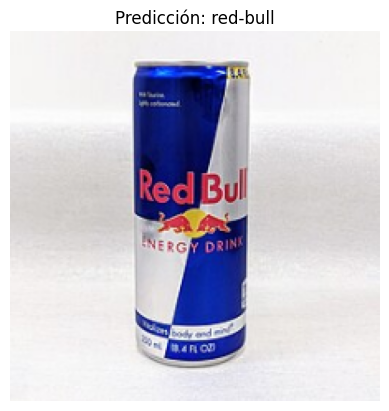

Clases disponibles: ['Banana', 'Orange', 'Red-Bell-Pepper', 'aluminium-form', 'bread', 'cocaCola', 'doritos', 'red-bull', 'shampoo-H&S', 'tea', 'yogurt-toni-mix']
Muestras por clase:
   Banana: 6 muestras
   Orange: 5 muestras
   Red-Bell-Pepper: 5 muestras
   aluminium-form: 5 muestras
   bread: 5 muestras
   cocaCola: 9 muestras
   doritos: 10 muestras
   red-bull: 5 muestras
   shampoo-H&S: 5 muestras
   tea: 5 muestras
   yogurt-toni-mix: 5 muestras


In [38]:
def predecir_imagen(modelo, scaler, ruta_imagen, etiquetas, image_size=(224,224)):
    img = cv2.imread(ruta_imagen)
    img = cv2.resize(img, image_size)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    x = img_rgb.flatten().reshape(1, -1)
    x_scaled = scaler.transform(x)

    pred = modelo.predict(x_scaled)[0]
    etiquetas_predichas = [etiquetas[i] for i, v in enumerate(pred) if v == 1]

    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(f"Predicción: {', '.join(etiquetas_predichas)}")
    plt.show()

# Ejemplo de uso:
etiquetas = train_df.columns[1:]
predecir_imagen(multi_knn, scaler, 'ImagenesPrueba/rb.jpg', etiquetas)

# Obtener índices de cada clase en el set de validación
class_indices = {}
for i, clase in enumerate(etiquetas):
    indices = [j for j, labels in enumerate(y_val) if labels[i] == 1]
    class_indices[clase] = indices

print("Clases disponibles:", list(etiquetas))
print("Muestras por clase:")
for clase, indices in class_indices.items():
    print(f"   {clase}: {len(indices)} muestras")